<a href="https://colab.research.google.com/github/Kaiking28/ECON3916-Statistical-Machine-Learning/blob/main/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Netflix Standard', 'Price_2016': 9.99, 'Price_2024': 15.49}

]

In [70]:

# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")


Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Netflix Standard: 55.06% Inflation


In [71]:
from fredapi import Fred
fred = Fred(api_key='6a4da7a639a7c98bf5e2531d3ea1b4fe')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')  # Overall CPI
tuition = fred.get_series('CUSR0000SEEB')   # College tuition and fees
rent = fred.get_series('CUSR0000SEHA')      # Rent of primary residence
food_away = fred.get_series('CUSR0000SEFV') # Food away from home (Chipotle)
streaming = fred.get_series('CUSR0000SERA') # Recreation (Netflix/streaming)


In [72]:
import pandas as pd

df = pd.DataFrame({
    'CPI': official_cpi,
    'Tuition': tuition,
    'Rent': rent,
    'Food_away': food_away,
    'Streaming': streaming
})

df = df.loc['2016':'2024']

start_date = '2016-01-01'

df_normalized = pd.DataFrame()

for column in df.columns:
    value_at_start = df.loc[start_date, column]
    df_normalized[column] = (df[column] / value_at_start) * 100

df_normalized

,CPI,Tuition,Rent,Food_away,Streaming
2016-01-01,100.000000,100.000000,100.000000,100.000000,100.000000
2016-02-01,99.867032,100.241572,100.314364,100.138869,100.419508
2016-03-01,100.180095,100.470288,100.607131,100.355827,100.879064
2016-04-01,100.563850,100.692146,100.924580,100.599712,101.143383
2016-05-01,100.801592,100.929861,101.258485,100.813978,101.313589
...,...,...,...,...,...
2024-08-01,132.181088,123.818388,144.904697,142.464552,117.863615
2024-09-01,132.484052,124.539534,145.329105,142.947707,117.753482
2024-10-01,132.784071,124.849106,145.769626,143.286993,117.734459
2024-11-01,133.156464,125.191108,146.131299,143.688596,117.463130


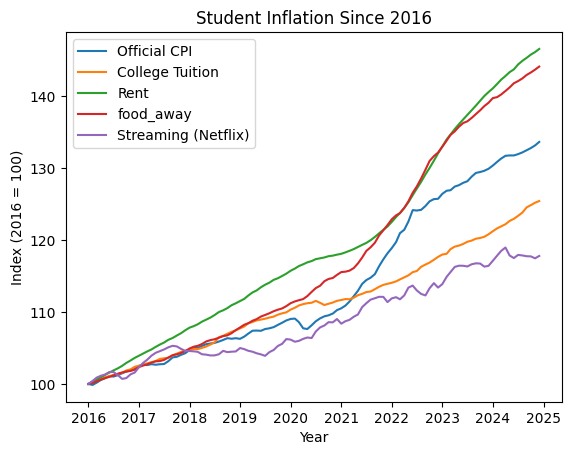

In [73]:
import matplotlib.pyplot as plt

plt.plot(df_normalized['CPI'], label='Official CPI')
plt.plot(df_normalized['Tuition'], label='College Tuition')
plt.plot(df_normalized['Rent'], label='Rent')
plt.plot(df_normalized['Food_away'], label='food_away')
plt.plot(df_normalized['Streaming'], label='Streaming (Netflix)')
plt.title('Student Inflation Since 2016')
plt.xlabel('Year')
plt.ylabel('Index (2016 = 100)')
plt.legend()
plt.show()

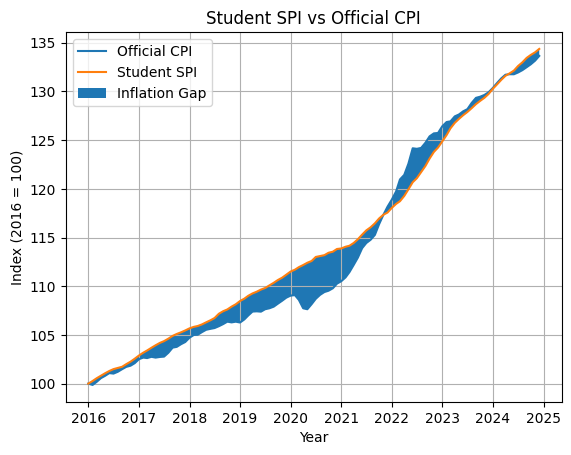

In [74]:
weights = {
    'Tuition': 0.35,
    'Rent': 0.30,
    'Food_away': 0.20,
    'Streaming': 0.15
}

df_normalized['Student_SPI'] = (
    df_normalized['Tuition'] * weights['Tuition'] +
    df_normalized['Rent'] * weights['Rent'] +
    df_normalized['Food_away'] * weights['Food_away'] +
    df_normalized['Streaming'] * weights['Streaming']
)

# Step 3: Plot Student SPI vs Official CPI with fill_between
plt.plot(df_normalized['CPI'], label='Official CPI')
plt.plot(df_normalized['Student_SPI'], label='Student SPI')
plt.fill_between(df_normalized.index,
                 df_normalized['CPI'],
                 df_normalized['Student_SPI'],
                 label='Inflation Gap')
plt.title('Student SPI vs Official CPI')
plt.xlabel('Year')
plt.ylabel('Index (2016 = 100)')
plt.legend()
plt.grid()
plt.show()


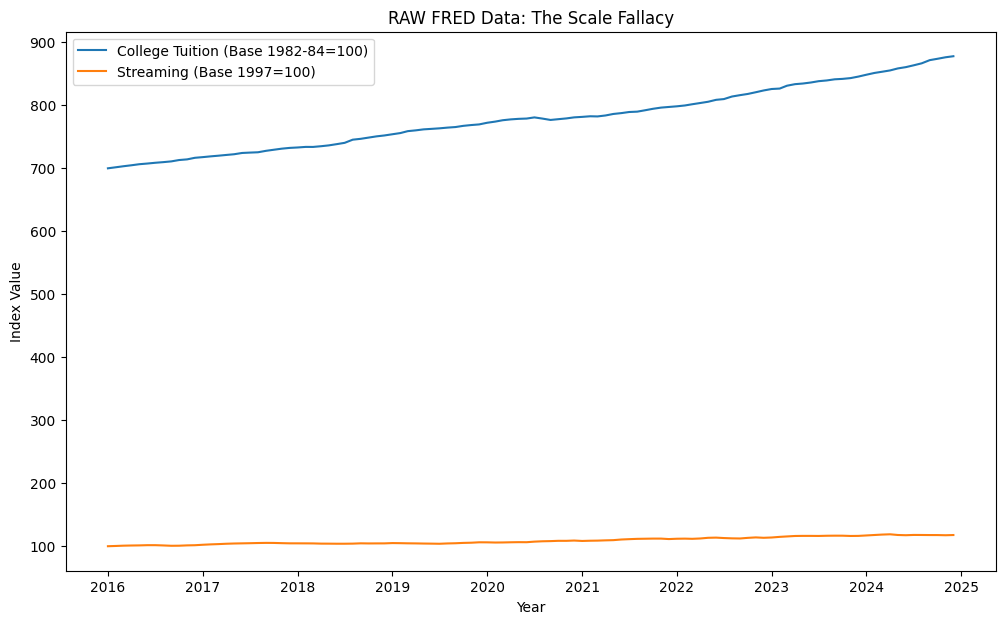

In [75]:
plt.figure(figsize=(12, 7))
plt.plot(df['Tuition'], label='College Tuition (Base 1982-84=100)')
plt.plot(df['Streaming'], label='Streaming (Base 1997=100)')
plt.title('RAW FRED Data: The Scale Fallacy')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.show()


/tmp/ipython-input-2215840848.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_normalized['Boston_CPI'] = df_normalized['Boston_CPI'].fillna(method='ffill')


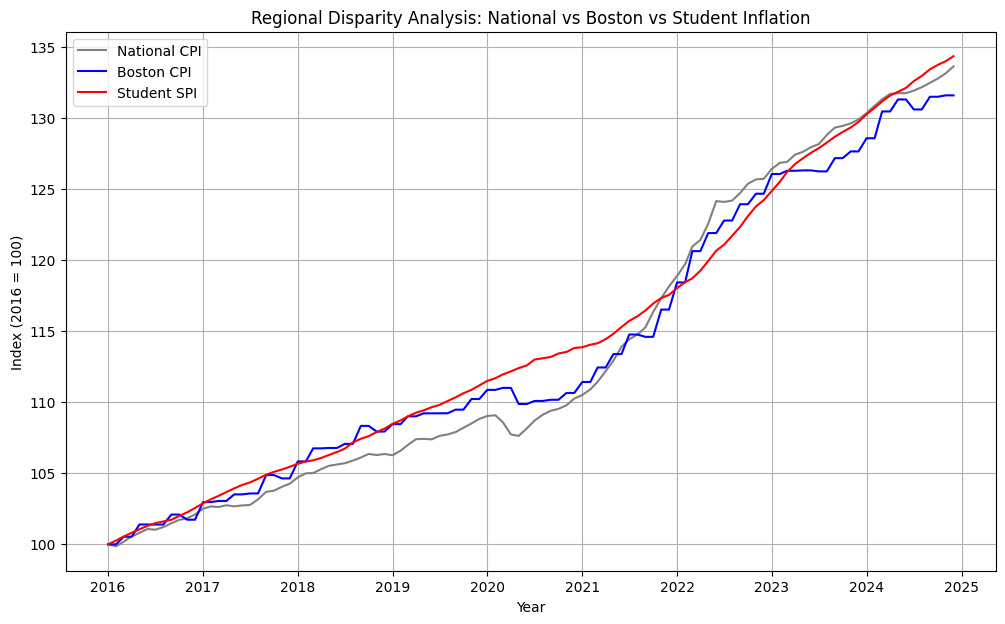


2024 Index Values (2016=100):
National CPI: 133.6
Boston CPI: 131.6
Student SPI: 134.4


In [76]:
#claude code

# Fetch Boston CPI
boston_cpi = fred.get_series('CUURA103SA0')

# Add to DataFrame
df['Boston_CPI'] = boston_cpi

# Filter to 2016-2024
df = df.loc['2016':'2024']

# Normalize Boston CPI to Jan 1, 2016 = 100
start_date = '2016-01-01'
df_normalized['Boston_CPI'] = (df['Boston_CPI'] / df.loc[start_date, 'Boston_CPI']) * 100

# Handle missing values (forward fill if bimonthly)
df_normalized['Boston_CPI'] = df_normalized['Boston_CPI'].fillna(method='ffill')

# Plot THREE lines
plt.figure(figsize=(12, 7))
plt.plot(df_normalized['CPI'], label='National CPI', color='grey')
plt.plot(df_normalized['Boston_CPI'], label='Boston CPI', color='blue')
plt.plot(df_normalized['Student_SPI'], label='Student SPI', color='red')
plt.title('Regional Disparity Analysis: National vs Boston vs Student Inflation')
plt.xlabel('Year')
plt.ylabel('Index (2016 = 100)')
plt.legend()
plt.grid()
plt.show()

print(f"\n2024 Index Values (2016=100):")
print(f"National CPI: {df_normalized['CPI'].iloc[-1]:.1f}")
print(f"Boston CPI: {df_normalized['Boston_CPI'].iloc[-1]:.1f}")
print(f"Student SPI: {df_normalized['Student_SPI'].iloc[-1]:.1f}")